<a href="https://colab.research.google.com/github/alouwyck/vives-deep-learning/blob/main/topic17/4_LangChain_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

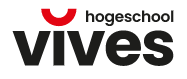<br>


**DEEP LEARNING**<br>
Academiejaar 2024-2025<br>
Andy Louwyck

---



---



# **LangChain: Retrieval Augmented Generation**

One of the most powerful applications enabled by LLMs is sophisticated question-answering (Q&A) chatbots. These are applications that can answer questions about specific source information. These applications use a technique known as Retrieval Augmented Generation, or RAG.

Basically, RAG is a technique for augmenting LLM knowledge with additional data. This notebook introduces some key LangChain concepts relevant to RAG and demonstrates their application in building simple RAG applications. Before diving into the code, it is explained in more detail what RAG is.


## **What is RAG?**

LLMs can reason about wide-ranging topics, but their knowledge is limited to the public data up to a specific point in time that they were trained on. If you want to build AI applications that can reason about private data or data introduced after a model's cutoff date, you need to augment the knowledge of the model with the specific information it needs. The process of bringing the appropriate information and inserting it into the model prompt is known as Retrieval Augmented Generation, which is abbreviated as RAG.

LangChain has a number of components designed to help build Q&A applications, and RAG applications more generally. In this notebook, we focus on Q&A for unstructured data, but RAG over structured data, such as SQL data, is also possible.

A typical RAG application has two main components:

- *Indexing* : a pipeline for ingesting data from a source and indexing it. This usually happens offline.

- *Retrieval* and *generation* : the actual RAG chain, which takes the user query at run time and retrieves the relevant data from the index, then passes that to the model.

The most common full sequence from raw data to answer looks like:

**Indexing**

1. *Load* : First we need to load our data. This is done with document loaders.
2. *Split* : Text splitters break large documents into smaller chunks. This is useful both for indexing data and for passing it in to a model, since large chunks are harder to search over and won't fit in a model's finite context window.
3. *Store* : We need somewhere to store and index our splits, so that they can later be searched over. This is often done using a vector store and an embeddings model.

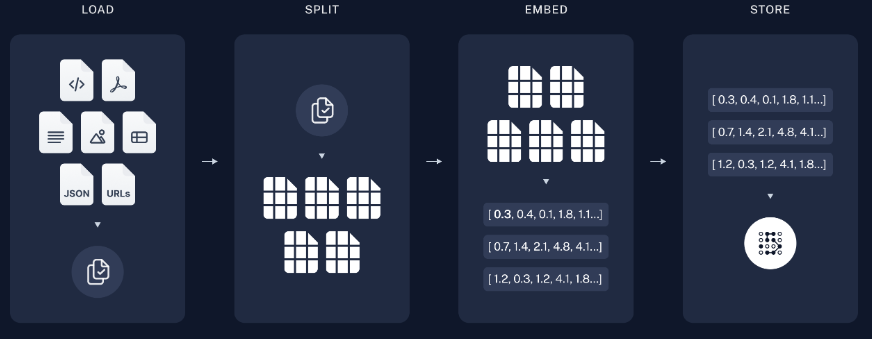

**Retrieval and generation**

4. *Retrieve* : Given a user input, relevant splits are retrieved from storage using a retriever.
5. *Generate* : A chat model or LLM produces an answer using a prompt that includes the question and the retrieved data.


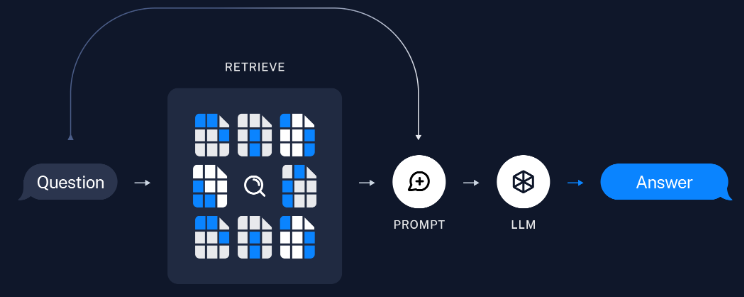

## **Setup**

In this notebook, we'll walk through two LangChain tutorials which require `langchain` and `langchain-chroma`. Instead of using an embedding model by OpenAI as suggested by these tutorials, we'll apply the BGE model from HuggingFace, which is currently one of the best open-source embedding models:

https://python.langchain.com/v0.2/docs/integrations/text_embedding/bge_huggingface/

That is why we also import `langchain-community` and `sentence_transformers`. Because we'll build very simple RAG applications using Llama3, we also need to import `langchain-groq`, and we need `langchainhub` so we're able to pull a prompt for RAG from the LangChain prompt hub.

In [ ]:
!pip install -q langchain langchain-community langchain-chroma langchain-groq langchainhub sentence_transformers

Setting the LangChain and Groq API keys as environment variables:

In [3]:
import os
from google.colab import userdata
for key in ['LANGCHAIN_API_KEY', 'GROQ_API_KEY']:
    os.environ[key] = userdata.get(key)

It takes some time to install these packages, so in the meantime, you may read the following section explaining some important RAG concepts.

## **RAG Concepts**

In this section, we discuss the following LangChain concepts and techniques that are relevant to RAG:

- Documents
- Document loaders
- Text splitters
- Embedding models
- Vector stores
- Retrievers

In the next sections, we'll apply these concepts and techniques to build simple RAG applications.

A detailed overview of LangChain architecture, concepts, and techniques can be found here: https://python.langchain.com/v0.2/docs/concepts.

### Documents

A `Document` object in LangChain contains information about some data. It has two attributes:

- `page_content` (`str`): The content of the document. Currently is only a string.
- `metadata` (`dict`): Arbitrary metadata associated with this document. Can track the document id, file name, etc.

### Document loaders

These classes load `Document` objects. LangChain has hundreds of integrations with various data sources to load data from: Slack, Notion, Google Drive, etc.

Each `DocumentLoader` has its own specific parameters, but they can all be invoked in the same way with the `load` method. An example use case is as follows:

```python
from langchain_community.document_loaders.csv_loader import CSVLoader

loader = CSVLoader(
    ...  # <-- Integration specific parameters here
)
data = loader.load()
```

### Text splitters

Once you've loaded documents, you'll often want to transform them to better suit your application. The simplest example is you may want to split a long document into smaller chunks that can fit into your model's context window. LangChain has a number of built-in document transformers that make it easy to split, combine, filter, and otherwise manipulate documents.

When you want to deal with long pieces of text, it is necessary to split up that text into chunks. As simple as this sounds, there is a lot of potential complexity here. Ideally, you want to keep the semantically related pieces of text together. What "semantically related" means could depend on the type of text.

At a high level, text splitters work as following:

1. Split the text up into small, semantically meaningful chunks (often sentences).
2. Start combining these small chunks into a larger chunk until you reach a certain size (as measured by some function).
3. Once you reach that size, make that chunk its own piece of text and then start creating a new chunk of text with some overlap (to keep context between chunks).

That means there are two different axes along which you can customize your text splitter:

1. How the text is split
2. How the chunk size is measured

### Embedding models

Embedding models create a vector representation of a piece of text. You can think of a vector as an array of numbers that captures the semantic meaning of the text. By representing the text in this way, you can perform mathematical operations that allow you to do things like search for other pieces of text that are most similar in meaning. These natural language search capabilities underpin many types of context retrieval, where we provide an LLM with the relevant data it needs to effectively respond to a query.

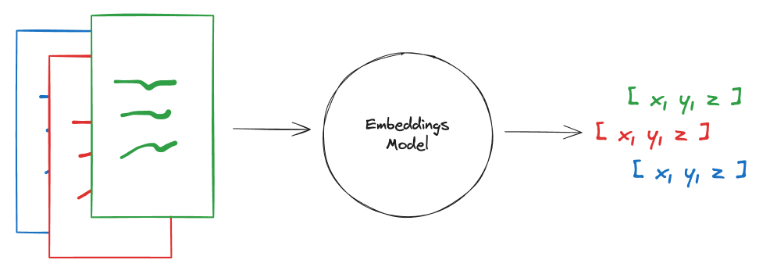

The `Embeddings` class is designed for interfacing with text embedding models. There are many different embedding model providers (OpenAI, Cohere, Hugging Face, etc.) and local models, and this class is designed to provide a standard interface for all of them.

The base `Embeddings` class in LangChain provides two methods: one for embedding documents and one for embedding a query. The former takes as input multiple texts, while the latter takes a single text. The reason for having these as two separate methods is that some embedding providers have different embedding methods for documents (to be searched over) vs queries (the search query itself).

### Vector stores

One of the most common ways to store and search over unstructured data is to embed it and store the resulting embedding vectors, and then at query time to embed the unstructured query and retrieve the embedding vectors that are 'most similar' to the embedded query. A vector store takes care of storing embedded data and performing vector search for you.

Most vector stores can also store metadata about embedded vectors and support filtering on that metadata before similarity search, allowing you more control over returned documents.

Vector stores can be converted to the retriever interface by doing:

```python
vectorstore = MyVectorStore()
retriever = vectorstore.as_retriever()
```

### Retrievers

A retriever is an interface that returns documents given an unstructured query. It is more general than a vector store. A retriever does not need to be able to store documents, only to return (or retrieve) them. Retrievers can be created from vector stores, but are also broad enough to include, for instance, Wikipedia search and Amazon Kendra. Retrievers accept a string query as input and return a list of documents as output.

## **Vector Stores and Retrievers**

As explained in previous section, vector stores and retrievers are LanchChain abstractions that are designed to support retrieval of data - from (vector) databases and other sources - for integration with LLM workflows. They are important for applications that fetch data to be reasoned over as part of model inference, as in the case of RAG. To get us familiarized with LangChain's vector store and retriever abstractions, we go through this tutorial: https://python.langchain.com/v0.2/docs/tutorials/retrievers/.

In particular, the tutorial focuses on retrieval of text data. It will cover the following concepts:

- Documents;
- Embedding models;
- Vector stores;
- Retrievers.



### Documents

As already explained in previous section, LangChain implements a `Document` abstraction, which is intended to represent a unit of text and associated metadata. It has two attributes:

- `page_content`: a string representing the content;
- `metadata`: a dictionary containing arbitrary metadata.

The `metadata` attribute can capture information about the source of the document, its relationship to other documents, and other information. Note that an individual `Document` object often represents a chunk of a larger document.

Let's generate some sample documents:

In [ ]:
from langchain_core.documents import Document

documents = [
    Document(
        page_content="Dogs are great companions, known for their loyalty and friendliness.",
        metadata={"source": "mammal-pets-doc"},
    ),
    Document(
        page_content="Cats are independent pets that often enjoy their own space.",
        metadata={"source": "mammal-pets-doc"},
    ),
    Document(
        page_content="Goldfish are popular pets for beginners, requiring relatively simple care.",
        metadata={"source": "fish-pets-doc"},
    ),
    Document(
        page_content="Parrots are intelligent birds capable of mimicking human speech.",
        metadata={"source": "bird-pets-doc"},
    ),
    Document(
        page_content="Rabbits are social animals that need plenty of space to hop around.",
        metadata={"source": "mammal-pets-doc"},
    ),
]

documents

[Document(metadata={'source': 'mammal-pets-doc'}, page_content='Dogs are great companions, known for their loyalty and friendliness.'),
 Document(metadata={'source': 'mammal-pets-doc'}, page_content='Cats are independent pets that often enjoy their own space.'),
 Document(metadata={'source': 'fish-pets-doc'}, page_content='Goldfish are popular pets for beginners, requiring relatively simple care.'),
 Document(metadata={'source': 'bird-pets-doc'}, page_content='Parrots are intelligent birds capable of mimicking human speech.'),
 Document(metadata={'source': 'mammal-pets-doc'}, page_content='Rabbits are social animals that need plenty of space to hop around.')]

Here we've generated five documents, containing metadata indicating three distinct "sources".

### Vector Stores

Vector search is a common way to store and search over unstructured data (such as unstructured text). The idea is to store numeric vectors that are associated with the text. Given a query, we can embed it as a vector of the same dimension and use vector similarity metrics, such as the cosine similarity, to identify related data in the store.

LangChain `VectorStore` objects contain methods for adding text and `Document` objects to the store, and querying them using various similarity metrics. They are often initialized with embedding models, which determine how text data is translated to numeric vectors.

LangChain includes a suite of integrations with different vector store technologies. Some vector stores are hosted by a provider (e.g., various cloud providers) and require specific credentials to use; some (such as Postgres) run in separate infrastructure that can be run locally or via a third-party; others can run in-memory for lightweight workloads. Here we will demonstrate usage of LangChain vector stores using `Chroma`, which includes an in-memory implementation.

To instantiate a vector store, we often need to provide an embedding model to specify how text should be converted into a numeric vector. As already indicated we'll use the BGE embedding model from HuggingFace:

https://api.python.langchain.com/en/latest/embeddings/langchain_community.embeddings.huggingface.HuggingFaceBgeEmbeddings.html

In [ ]:
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-large-en"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True}
hf = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

Calling method `from_documents` here will add the documents to the vector store. `VectorStore` implements methods for adding documents that can also be called after the object is instantiated. Most implementations will allow you to connect to an existing vector store - e.g., by providing a client, index name, or other information. See the LangChain documentation for a specific integration for more detail.

In [ ]:
from langchain_chroma import Chroma

vectorstore = Chroma.from_documents(
    documents,
    embedding=hf,
)

Once we've instantiated a `VectorStore` object that contains documents, we can query it. `VectorStore` includes methods for querying:

- Synchronously and asynchronously;
- By string query and by vector;
- With and without returning similarity scores;
- By similarity and maximum marginal relevance (to balance similarity with query to diversity in retrieved results).

The methods will generally include a list of `Document` objects in their outputs.

### Examples

Return documents based on similarity to a string query:

In [ ]:
vectorstore.similarity_search("cat")

[Document(metadata={'source': 'mammal-pets-doc'}, page_content='Cats are independent pets that often enjoy their own space.'),
 Document(metadata={'source': 'fish-pets-doc'}, page_content='Goldfish are popular pets for beginners, requiring relatively simple care.'),
 Document(metadata={'source': 'mammal-pets-doc'}, page_content='Dogs are great companions, known for their loyalty and friendliness.'),
 Document(metadata={'source': 'bird-pets-doc'}, page_content='Parrots are intelligent birds capable of mimicking human speech.')]

The corresponding asynchronous query:

In [ ]:
await vectorstore.asimilarity_search("cat")

[Document(metadata={'source': 'mammal-pets-doc'}, page_content='Cats are independent pets that often enjoy their own space.'),
 Document(metadata={'source': 'fish-pets-doc'}, page_content='Goldfish are popular pets for beginners, requiring relatively simple care.'),
 Document(metadata={'source': 'mammal-pets-doc'}, page_content='Dogs are great companions, known for their loyalty and friendliness.'),
 Document(metadata={'source': 'bird-pets-doc'}, page_content='Parrots are intelligent birds capable of mimicking human speech.')]

In the context of database or API interactions, "sync" (synchronous) and "async" (asynchronous) refer to how the code execution handles waiting for a response.

*Synchronous queries*:
- The code execution pauses and waits for the query to complete before moving on to the next line.
- Simpler to write and understand, but can lead to performance bottlenecks if the query takes a long time.

*Asynchronous queries*:
- The code execution continues without waiting for the query to complete.
- Allows for other tasks to be performed while the query is running in the background, improving efficiency.
- Requires more complex code to handle the eventual response.

In the provided code, you have both `similarity_search` (synchronous) and `asimilarity_search` (asynchronous) methods for the vector store. The choice depends on whether you need the results immediately or can perform other operations while waiting.

The `await` keyword is used in Python to work with asynchronous functions. In our code, `asimilarity_search` is defined as an asynchronous coroutine, meaning it doesn't immediately return the result. When you use `await` before calling `asimilarity_search`, it tells Python to pause the execution of the current coroutine until the `asimilarity_search` function completes and returns its result. This allows other tasks to run in the background while waiting for the search to finish, improving efficiency. Essentially, `await` is necessary to properly interact with asynchronous functions and retrieve their results in a non-blocking manner.

It is also possible to get the scores:

In [ ]:
vectorstore.similarity_search_with_score("cat")

[(Document(metadata={'source': 'mammal-pets-doc'}, page_content='Cats are independent pets that often enjoy their own space.'),
  0.4406493306159973),
 (Document(metadata={'source': 'fish-pets-doc'}, page_content='Goldfish are popular pets for beginners, requiring relatively simple care.'),
  0.548194169998169),
 (Document(metadata={'source': 'mammal-pets-doc'}, page_content='Dogs are great companions, known for their loyalty and friendliness.'),
  0.5544476509094238),
 (Document(metadata={'source': 'bird-pets-doc'}, page_content='Parrots are intelligent birds capable of mimicking human speech.'),
  0.5609818696975708)]

Note that providers implement different scores; `Chroma` here returns a distance metric that should vary inversely with similarity.



The query itself can also be embedded as a vector. In this case, we call `similarity_search_by_vector`, which returns documents based on similarity to an embedded query:

In [ ]:
embedding = hf.embed_query("cat")
vectorstore.similarity_search_by_vector(embedding)

[Document(metadata={'source': 'mammal-pets-doc'}, page_content='Cats are independent pets that often enjoy their own space.'),
 Document(metadata={'source': 'fish-pets-doc'}, page_content='Goldfish are popular pets for beginners, requiring relatively simple care.'),
 Document(metadata={'source': 'mammal-pets-doc'}, page_content='Dogs are great companions, known for their loyalty and friendliness.'),
 Document(metadata={'source': 'bird-pets-doc'}, page_content='Parrots are intelligent birds capable of mimicking human speech.')]

### Retrievers

LangChain `VectorStore` objects do not subclass `Runnable`, and so cannot immediately be integrated into LangChain Expression Language (LCEL) chains.

LangChain `Retriever` objects are instances of `Runnable`, so they implement a standard set of methods (e.g., synchronous and asynchronous invoke and batch operations) and are designed to be incorporated in LCEL chains.

We can create a simple version of this ourselves, without subclassing `Retriever`. If we choose what method we wish to use to retrieve documents, we can create a `Runnable` easily. Below we will build one around the `similarity_search` method:

In [ ]:
from typing import List
from langchain_core.documents import Document
from langchain_core.runnables import RunnableLambda

retriever = RunnableLambda(vectorstore.similarity_search).bind(k=1)  # select top result (= nearest neighbor)
retriever.batch(["cat", "shark"])

[[Document(metadata={'source': 'mammal-pets-doc'}, page_content='Cats are independent pets that often enjoy their own space.')],
 [Document(metadata={'source': 'mammal-pets-doc'}, page_content='Dogs are great companions, known for their loyalty and friendliness.')]]

Because we perform two queries in 'batch', we get two documents as result. The second document is a bit strange as the document about the goldfish is expected to be more similar to `"shark"`...

The `VectorStore` class implements an `as_retriever` method that will generate a `Retriever`, specifically a `VectorStoreRetriever`. These retrievers include specific `search_type` and `search_kwargs` attributes that identify what methods of the underlying vector store to call, and how to parameterize them. For instance, we can replicate the above with the following:

In [ ]:
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 1},  # kwargs = keyword arguments -> dict!
)

retriever.batch(["cat", "shark"])

[[Document(metadata={'source': 'mammal-pets-doc'}, page_content='Cats are independent pets that often enjoy their own space.')],
 [Document(metadata={'source': 'mammal-pets-doc'}, page_content='Dogs are great companions, known for their loyalty and friendliness.')]]

This second way of creating a retriever is probably the easiest one. Note that `VectorStoreRetriever` supports search types of `"similarity"` (default), `"mmr"` (maximum marginal relevance), and `"similarity_score_threshold"`. We can use the latter to threshold documents output by the retriever by similarity score instead of specifying `"k"`.

Finally, retrievers can easily be incorporated into more complex applications, such as retrieval-augmented generation (RAG) applications that combine a given question with retrieved context into a prompt for a LLM. Below we show a minimal example using Llama3.

Instanciating the LLM:

In [ ]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama3-8b-8192")

Creating the prompt:

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

message = """
Answer this question using the provided context only.

{question}

Context:
{context}
"""

prompt = ChatPromptTemplate.from_messages([("human", message)])
prompt

ChatPromptTemplate(input_variables=['context', 'question'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template='\nAnswer this question using the provided context only.\n\n{question}\n\nContext:\n{context}\n'))])

Invoking the RAG chain:

In [ ]:
from langchain_core.runnables import RunnablePassthrough

rag_chain = {"context": retriever, "question": RunnablePassthrough()} | prompt | llm

response = rag_chain.invoke("tell me about cats")
print(response.content)

According to the provided context, cats are independent pets that often enjoy their own space.


In the next section, a more advanced RAG application is developed.

## **Build a RAG App**

This section will show how to build a simple Q&A application over a text data source. Along the way we'll go over a typical Q&A architecture. The code example is adopted from the following LangChain tutorial: https://python.langchain.com/v0.2/docs/tutorials/rag/.

In this tutorial an app that answers questions about the content of a website is build. The specific website we will use is the [LLM Powered Autonomous Agents](https://lilianweng.github.io/posts/2023-06-23-agent/) blog post by Lilian Weng, which allows us to ask questions about the contents of the post. We can create a simple indexing pipeline and RAG chain to do this in about 20 lines of code. Here, we go through the code step-by-step to really understand what's going on.


### Step 1: Indexing - Load

We need to first load the blog post contents. We can use document loaders for this, which are objects that load in data from a source and return a list of documents. Recall that a `Document` is an object with some `page_content` (`str`) and `metadata` (`dict`).

In this case we'll use the `WebBaseLoader`, which uses `urllib` to load HTML from web URLs and `BeautifulSoup` to parse it to text. We can customize the HTML to text parsing by passing in parameters to the `BeautifulSoup` parser via `bs_kwargs` (see [BeautifulSoup docs](https://beautiful-soup-4.readthedocs.io/en/latest/#beautifulsoup)). In this case only HTML tags with class `"post-content"`, `"post-title"`, or `"post-header"` are relevant, so we'll remove all others.

In [6]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

len(docs)  # one document only

1

Checking the number of characters in the page content:

In [7]:
len(docs[0].page_content)

43131

Printing the first 500 characters from the page content:

In [5]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


### Step 2: Indexing - Split

Our loaded document is over 42k characters long. This is too long to fit in the context window of many models. Even for those models that could fit the full post in their context window, models can struggle to find information in very long inputs. To handle this we'll split the `Document` into chunks for embedding and vector storage. This should help us retrieve only the most relevant bits of the blog post at run time.

In this case we'll split our documents into chunks of 1000 characters with 200 characters of overlap between chunks. The overlap helps mitigate the possibility of separating a statement from important context related to it. We use the `RecursiveCharacterTextSplitter`, which will recursively split the document using common separators like new lines until each chunk is the appropriate size. This is the recommended text splitter for generic text use cases.

We set `add_start_index=True` so that the character index at which each split `Document` starts within the initial `Document` is preserved as metadata attribute `"start_index"`:

In [11]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)
all_splits = text_splitter.split_documents(docs)

len(all_splits)

66

So the `Document` is split in 66 chunks. Let's check the minimum and maximum number of characters in these chunks:

In [14]:
print('min number of characters:', min(len(split.page_content) for split in all_splits))
print('max number of characters:', max(len(split.page_content) for split in all_splits))

min number of characters: 18
max number of characters: 999


As an example, we get the metadata from the 11-th chunk:

In [13]:
all_splits[10].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 7056}

### Step 3: Indexing - Store

Now we need to index our 66 text chunks so that we can search over them at runtime. The most common way to do this is to embed the contents of each document split and insert these embeddings into a vector database (or vector store). When we want to search over our splits, we take a text search query, embed it, and perform some sort of “similarity” search to identify the stored splits with the most similar embeddings to our query embedding. The simplest similarity measure is cosine similarity — we measure the cosine of the angle between each pair of embeddings (which are high dimensional vectors).

The LangChain tutorial makes use of the `OpenAIEmbeddings` model; we'll apply the open-source BGE model from Hugging Face as we did in previous section:

In [ ]:
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-large-en"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True}
hf_bge = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

Now, we can embed and store all of our document splits in a single command using the Chroma vector store and the BGE model:

In [18]:
from langchain_chroma import Chroma

vectorstore = Chroma.from_documents(documents=all_splits, embedding=hf_bge)

It takes some time to embed the document splits, but once it is done, the "indexing" portion of the pipeline is completed. At this point we have a query-able vector store containing the chunked contents of our blog post. Given a user question, we should ideally be able to return the snippets of the blog post that answer the question.

### Step 4: Retrieval and Generation - Retrieve

Now let's write the actual application logic. We want to create a simple application that takes a user question, searches for documents relevant to that question, passes the retrieved documents and initial question to a model, and returns an answer.

First we need to define our logic for searching over documents. LangChain defines a `Retriever` interface which wraps an index that can return relevant `Document` objects given a string query.

The most common type of `Retriever` is the `VectorStoreRetriever`, which uses the similarity search capabilities of a vector store to facilitate retrieval. Any `VectorStore` can easily be turned into a `Retriever` with `VectorStore.as_retriever()`:

In [19]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 6})
retrieved_docs = retriever.invoke("What are the approaches to Task Decomposition?")
len(retrieved_docs)

6

As expected, 6 documents are retrieved, because we've set `"k"` to 6, meaning we want the 6 most similar documents.

Let's read the first retrieved document:

In [20]:
print(retrieved_docs[0].page_content)

Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.


### Step 5: Retrieval and Generation - Generate

Let's put it all together into a chain that takes a question, retrieves relevant documents, constructs a prompt, passes that to a model, and parses the output. Instead of using the gpt-3.5-turbo OpenAI chat model, we'll use Llama 3 via Groq:

In [21]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama3-8b-8192")

We'll use a [prompt for RAG](https://smith.langchain.com/hub/rlm/rag-prompt) that is checked into the LangChain prompt hub:

In [24]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "filler context", "question": "filler question"}
).to_messages()

example_messages

[HumanMessage(content="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: filler question \nContext: filler context \nAnswer:")]

There is only one message, a `HumanMessage` object having the following content:

In [26]:
example_messages[0].content

"You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: filler question \nContext: filler context \nAnswer:"

We'll use the LCEL Runnable protocol to define the chain, allowing us to pipe together components and functions in a transparent way, automatically trace our chain in LangSmith, and get streaming, async, and batched calling out of the box.

Here is the implementation:

In [28]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

for chunk in rag_chain.stream("What is Task Decomposition?"):
    print(chunk, end="", flush=True)

Task Decomposition refers to the process of breaking down a complex task into smaller, manageable steps, allowing an agent to plan ahead and utilize more test-time computation. This can be achieved through techniques such as Chain of Thought or Tree of Thoughts, which involve instructing the model to "think step by step" and generate multiple thoughts per step.

Let's dissect the LCEL to understand what's going on.

First: each of these components (`retriever`, `prompt`, `llm`, etc.) are instances of `Runnable`. This means that they implement the same methods, such as sync and async `invoke`, `stream`, or `batch`, which makes them easier to connect together. They can be connected into a `RunnableSequence` - another `Runnable` - via the `|` operator.

LangChain will automatically cast certain objects to runnables when met with the `|` operator. Here, `format_docs` is cast to a `RunnableLambda`, and the `dict` with `"context"` and `"question"` is cast to a `RunnableParallel`. The details are less important than the bigger point, which is that each object is a `Runnable`.

Let's trace how the input question flows through the above runnables.

As we've seen above, the input to `prompt` is expected to be a `dict` with keys `"context"` and `"question"`. So the first element of this chain builds runnables that will calculate both of these from the input question:
- `retriever | format_docs` passes the question through the retriever, generating `Document objects`, and then to `format_docs` to generate strings;
- `RunnablePassthrough()` passes through the input question unchanged.

That is, if you constructed:

In [30]:
chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
)

Then `chain.invoke(question)` would build a formatted prompt, ready for inference:

In [31]:
chain.invoke("What is Taks Decomposition?")

ChatPromptValue(messages=[HumanMessage(content='You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don\'t know the answer, just say that you don\'t know. Use three sentences maximum and keep the answer concise.\nQuestion: What is Taks Decomposition? \nContext: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\n\nFig. 1. Over

Note: when developing with LCEL, it can be practical to test with sub-chains like this.

The last steps of the chain are `llm`, which runs the inference, and `StrOutputParser()`, which just plucks the string content out of the LLM's output message.

As shown above, we can load prompts (e.g., this RAG prompt) from the prompt hub. The prompt can also be easily customized:

In [34]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""


custom_rag_prompt = PromptTemplate.from_template(template)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | custom_rag_prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What is Task Decomposition?")

'Task Decomposition is a technique used in LLM-powered autonomous agent systems to break down a complicated task into smaller and simpler steps. This is done by instructing the model to "think step by step" and decompose hard tasks into manageable tasks. Thanks for asking!'

### Built-in chains

If preferred, LangChain includes convenience functions that implement the above LCEL. We compose two functions:

- `create_stuff_documents_chain` specifies how retrieved context is fed into a prompt and LLM. In this case, we will "stuff" the contents into the prompt - i.e., we will include all retrieved context without any summarization or other processing. It largely implements our above `rag_chain`, with input keys `context` and `input` - it generates an answer using retrieved context and query.
- `create_retrieval_chain` adds the retrieval step and propagates the retrieved context through the chain, providing it alongside the final answer. It has input key `input`, and includes `input`, `context`, and `answer` in its output.

In [32]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)


question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

response = rag_chain.invoke({"input": "What is Task Decomposition?"})
print(response["answer"])

Task Decomposition is a technique used in planning to break down a complex task into smaller, more manageable subtasks. This helps to simplify the task and make it easier to plan and execute. It can be done using techniques like Chain of Thought or Tree of Thoughts, which involve prompting the model to think step-by-step or explore multiple reasoning possibilities at each step.


Often in Q&A applications it's important to show users the sources that were used to generate the answer. LangChain's built-in `create_retrieval_chain` will propagate retrieved source documents through to the output in the `context` key:



In [33]:
for document in response["context"]:
    print(document)
    print()

page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.' metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}

page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS 

### Next steps

Now you're familiar with basic retrieval, you might also be interested in this high-level overview of different retrieval techniques:

https://python.langchain.com/v0.2/docs/concepts/#retrieval

Highly recommended is the video series "RAG from scratch" by Lance Martin from LangChain:

https://www.youtube.com/playlist?list=PLfaIDFEXuae2LXbO1_PKyVJiQ23ZztA0x

---

## Sources

- [Generative AI with LangChain](https://www.packtpub.com/en-us/product/generative-ai-with-langchain-9781835083468) by Ben Auffrath (2023), textbook published by Packt Publishing.
- [LangChain v0.2 documentation](https://python.langchain.com/v0.2/docs/introduction/)
- Gemini integrated into Google Colab was applied to generate additional explanations about some of the Python syntax used in the examples.

---